#Testing the verbatin documentation to see if I can get multiple investment periods

In [2]:
#Packages 
import pypsa
import matplotlib.pyplot as plt 
import cartopy 
import geopandas
import networkx
import linopy
import cartopy.crs as ccrs
import atlite 
import geopandas as gpd 
import xarray
import pandas as pd 
from datetime import datetime
import numpy as np
from pypsa.plot import add_legend_patches
import random

## Overall view of colors matched to carriers 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [3]:
n = pypsa.Network()
years = [2020, 2030, 2040, 2050]
freq = "24"

snapshots = pd.DatetimeIndex([])
for year in years:
    period = pd.date_range(
        start="{}-01-01 00:00".format(year),
        freq="{}H".format(freq),
        periods=8760 / float(freq),
    )
    snapshots = snapshots.append(period)

# convert to multiindex and assign to network
n.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
n.investment_periods = years

n.snapshot_weightings

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_39808/3148991382.py:7: FutureWarning:

Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_39808/3148991382.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



objective  stores  generators
period timestep                                 
2020   2020-01-01        1.0     1.0         1.0
       2020-01-02        1.0     1.0         1.0
       2020-01-03        1.0     1.0         1.0
       2020-01-04        1.0     1.0         1.0
       2020-01-05        1.0     1.0         1.0
...                      ...     ...         ...
2050   2050-12-27        1.0     1.0         1.0
       2050-12-28        1.0     1.0         1.0
       2050-12-29        1.0     1.0         1.0
       2050-12-30        1.0     1.0         1.0
       2050-12-31        1.0     1.0         1.0

[1460 rows x 3 columns]

In [4]:
n.investment_periods

Index([2020, 2030, 2040, 2050], dtype='int32', name='period')

In [5]:
n.investment_period_weightings["years"] = list(np.diff(years)) + [10]

r = 0.01
T = 0
for period, nyears in n.investment_period_weightings.years.items():
    discounts = [(1 / (1 + r) ** t) for t in range(T, T + nyears)]
    n.investment_period_weightings.at[period, "objective"] = sum(discounts)
    T += nyears
n.investment_period_weightings

,objective,years
period,,
2020,9.566018,10
2030,8.659991,10
2040,7.839777,10
2050,7.097248,10


In [6]:
for i in range(3):
    n.add("Bus", "bus {}".format(i))

# add three lines in a ring
n.add(
    "Line",
    "line 0->1",
    bus0="bus 0",
    bus1="bus 1",
)

n.add(
    "Line",
    "line 1->2",
    bus0="bus 1",
    bus1="bus 2",
    capital_cost=10,
    build_year=2030,
)

n.add(
    "Line",
    "line 2->0",
    bus0="bus 2",
    bus1="bus 0",
)

n.lines["x"] = 0.0001
n.lines["s_nom_extendable"] = True

In [7]:
n.lines 

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
line 0->1,bus 0,bus 1,,0.0001,0.0,0.0,0.0,0.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line 1->2,bus 1,bus 2,,0.0001,0.0,0.0,0.0,0.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line 2->0,bus 2,bus 0,,0.0001,0.0,0.0,0.0,0.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# add some generators
p_nom_max = pd.Series(
    (np.random.uniform() for sn in range(len(n.snapshots))),
    index=n.snapshots,
    name="generator ext 2020",
)

# renewable (can operate 2020, 2030)
n.add(
    "Generator",
    "generator ext 0 2020",
    bus="bus 0",
    p_nom=50,
    build_year=2020,
    lifetime=20,
    marginal_cost=2,
    capital_cost=1,
    p_max_pu=p_nom_max,
    carrier="solar",
    p_nom_extendable=True,
)

# can operate 2040, 2050
n.add(
    "Generator",
    "generator ext 0 2040",
    bus="bus 0",
    p_nom=50,
    build_year=2040,
    lifetime=11,
    marginal_cost=25,
    capital_cost=10,
    carrier="OCGT",
    p_nom_extendable=True,
)

# can operate in 2040
n.add(
    "Generator",
    "generator fix 1 2040",
    bus="bus 1",
    p_nom=50,
    build_year=2040,
    lifetime=10,
    carrier="CCGT",
    marginal_cost=20,
    capital_cost=1,
)

n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
generator ext 0 2020,bus 0,PQ,,50.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
generator ext 0 2040,bus 0,PQ,,50.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
generator fix 1 2040,bus 1,PQ,,50.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [9]:
n.add(
    "StorageUnit",
    "storageunit non-cyclic 2030",
    bus="bus 2",
    p_nom=0,
    capital_cost=2,
    build_year=2030,
    lifetime=21,
    cyclic_state_of_charge=False,
    p_nom_extendable=False,
)

n.add(
    "StorageUnit",
    "storageunit periodic 2020",
    bus="bus 2",
    p_nom=0,
    capital_cost=1,
    build_year=2020,
    lifetime=21,
    cyclic_state_of_charge=True,
    cyclic_state_of_charge_per_period=True,
    p_nom_extendable=True,
)

n.storage_units

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
storageunit non-cyclic 2030,bus 2,PQ,,0.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,1.0,1.0,1.0,0.0,0.0,0.0
storageunit periodic 2020,bus 2,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,True,True,1.0,1.0,1.0,0.0,0.0,0.0


In [10]:
load_var = pd.Series(
    100 * np.random.rand(len(n.snapshots)), index=n.snapshots, name="load"
)
n.add("Load", "load 2", bus="bus 2", p_set=load_var)

load_fix = pd.Series(75, index=n.snapshots, name="load")
n.add("Load", "load 1", bus="bus 1", p_set=load_fix)

Index(['load 1'], dtype='object')

In [11]:
n.loads_t.p_set

Load               load 1     load 2
period timestep                     
2020   2020-01-01    75.0  13.360408
       2020-01-02    75.0  95.916318
       2020-01-03    75.0  29.044482
       2020-01-04    75.0  32.068029
       2020-01-05    75.0  43.284861
...                   ...        ...
2050   2050-12-27    75.0  92.585984
       2050-12-28    75.0  44.434205
       2050-12-29    75.0  40.599756
       2050-12-30    75.0  38.650594
       2050-12-31    75.0  49.124438

[1460 rows x 2 columns]

In [12]:
n.optimize(multi_investment_periods = True, solver_name = 'gurobi')

Index(['generator ext 0 2020', 'generator ext 0 2040', 'generator fix 1 2040'], dtype='object', name='Generator')
Index(['bus 0', 'bus 1', 'bus 2'], dtype='object', name='Bus')
Index(['line 0->1', 'line 1->2', 'line 2->0'], dtype='object', name='Line')
Index(['line 0->1', 'line 1->2', 'line 2->0'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 705.04it/s]
INFO:linopy.io: Writing time: 0.12s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-ygu2yk2z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-ygu2yk2z.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 32491 rows, 12417 columns, 63878 nonzeros


INFO:gurobipy:obj: 32491 rows, 12417 columns, 63878 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 32491 rows, 12417 columns and 63878 nonzeros


INFO:gurobipy:Optimize a model with 32491 rows, 12417 columns and 63878 nonzeros


Model fingerprint: 0x0d20af63


INFO:gurobipy:Model fingerprint: 0x0d20af63


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-05, 1e+01]


INFO:gurobipy:  Matrix range     [9e-05, 1e+01]


  Objective range  [1e+00, 2e+02]


INFO:gurobipy:  Objective range  [1e+00, 2e+02]


  Bounds range     [8e+03, 8e+03]


INFO:gurobipy:  Bounds range     [8e+03, 8e+03]


  RHS range        [3e-01, 1e+02]


INFO:gurobipy:  RHS range        [3e-01, 1e+02]


Presolve removed 24461 rows and 7668 columns


INFO:gurobipy:Presolve removed 24461 rows and 7668 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 8030 rows, 4749 columns, 20440 nonzeros


INFO:gurobipy:Presolved: 8030 rows, 4749 columns, 20440 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.934e+04


INFO:gurobipy: AA' NZ     : 1.934e+04


 Factor NZ  : 7.707e+04 (roughly 6 MB of memory)


INFO:gurobipy: Factor NZ  : 7.707e+04 (roughly 6 MB of memory)


 Factor Ops : 8.706e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.706e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.31966552e+08  1.66630464e+07  6.00e+02 3.15e+01  1.93e+05     0s


INFO:gurobipy:   0   3.31966552e+08  1.66630464e+07  6.00e+02 3.15e+01  1.93e+05     0s


   1   4.96376131e+07  3.64589044e+06  5.41e+01 8.97e+01  2.73e+04     0s


INFO:gurobipy:   1   4.96376131e+07  3.64589044e+06  5.41e+01 8.97e+01  2.73e+04     0s


   2   2.01313793e+07  1.46356410e+07  1.04e+00 4.06e+00  1.59e+03     0s


INFO:gurobipy:   2   2.01313793e+07  1.46356410e+07  1.04e+00 4.06e+00  1.59e+03     0s


   3   1.87352817e+07  1.79607037e+07  6.65e-12 2.09e-01  1.25e+02     0s


INFO:gurobipy:   3   1.87352817e+07  1.79607037e+07  6.65e-12 2.09e-01  1.25e+02     0s


   4   1.83402088e+07  1.82267621e+07  1.34e-11 5.06e-03  1.17e+01     0s


INFO:gurobipy:   4   1.83402088e+07  1.82267621e+07  1.34e-11 5.06e-03  1.17e+01     0s


   5   1.83331742e+07  1.82404924e+07  3.28e-11 1.99e-03  8.86e+00     0s


INFO:gurobipy:   5   1.83331742e+07  1.82404924e+07  3.28e-11 1.99e-03  8.86e+00     0s


   6   1.83244253e+07  1.82463481e+07  6.84e-11 6.38e-04  7.27e+00     0s


INFO:gurobipy:   6   1.83244253e+07  1.82463481e+07  6.84e-11 6.38e-04  7.27e+00     0s


   7   1.82931072e+07  1.82552680e+07  6.60e-10 1.45e-04  3.50e+00     0s


INFO:gurobipy:   7   1.82931072e+07  1.82552680e+07  6.60e-10 1.45e-04  3.50e+00     0s


   8   1.82849708e+07  1.82578938e+07  6.42e-10 1.03e-04  2.50e+00     0s


INFO:gurobipy:   8   1.82849708e+07  1.82578938e+07  6.42e-10 1.03e-04  2.50e+00     0s


   9   1.82844867e+07  1.82593363e+07  6.09e-10 5.42e-05  2.33e+00     0s


INFO:gurobipy:   9   1.82844867e+07  1.82593363e+07  6.09e-10 5.42e-05  2.33e+00     0s


  10   1.82755594e+07  1.82736125e+07  2.44e-09 2.96e-12  1.78e-01     0s


INFO:gurobipy:  10   1.82755594e+07  1.82736125e+07  2.44e-09 2.96e-12  1.78e-01     0s


  11   1.82752729e+07  1.82747142e+07  2.06e-10 1.11e-11  5.10e-02     0s


INFO:gurobipy:  11   1.82752729e+07  1.82747142e+07  2.06e-10 1.11e-11  5.10e-02     0s


  12   1.82751798e+07  1.82751649e+07  1.03e-09 1.14e-12  1.36e-03     0s


INFO:gurobipy:  12   1.82751798e+07  1.82751649e+07  1.03e-09 1.14e-12  1.36e-03     0s


  13   1.82751795e+07  1.82751795e+07  3.06e-10 4.55e-13  1.03e-06     0s


INFO:gurobipy:  13   1.82751795e+07  1.82751795e+07  3.06e-10 4.55e-13  1.03e-06     0s


  14   1.82751795e+07  1.82751795e+07  7.02e-10 3.76e-12  4.71e-12     0s


INFO:gurobipy:  14   1.82751795e+07  1.82751795e+07  7.02e-10 3.76e-12  4.71e-12     0s


INFO:gurobipy:


Barrier solved model in 14 iterations and 0.06 seconds (0.06 work units)


INFO:gurobipy:Barrier solved model in 14 iterations and 0.06 seconds (0.06 work units)


Optimal objective 1.82751795e+07


INFO:gurobipy:Optimal objective 1.82751795e+07


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


       4 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       4 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


    2175 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:    2175 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8334737e-14      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8334737e-14      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2182    1.8275179e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2182    1.8275179e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2182 iterations and 0.08 seconds (0.08 work units)


INFO:gurobipy:Solved in 2182 iterations and 0.08 seconds (0.08 work units)


Optimal objective  1.827517947e+07


INFO:gurobipy:Optimal objective  1.827517947e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 12417 primals, 32491 duals
Objective: 1.83e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

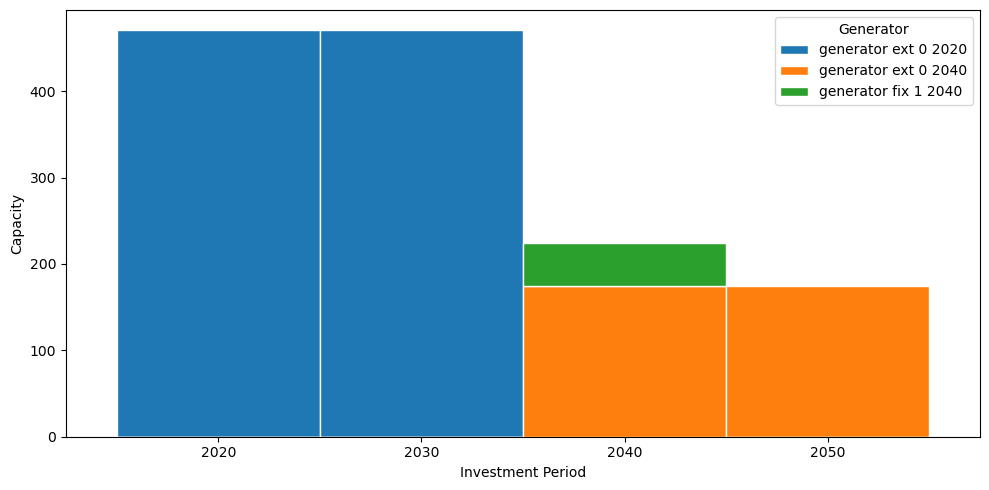

In [13]:
c = "Generator"
df = pd.concat(
    {
        period: n.get_active_assets(c, period) * n.df(c).p_nom_opt
        for period in n.investment_periods
    },
    axis=1,
)
df.T.plot.bar(
    stacked=True,
    edgecolor="white",
    width=1,
    ylabel="Capacity",
    xlabel="Investment Period",
    rot=0,
    figsize=(10, 5),
)
plt.tight_layout()

<Axes: xlabel='Investment Period', ylabel='Generation'>

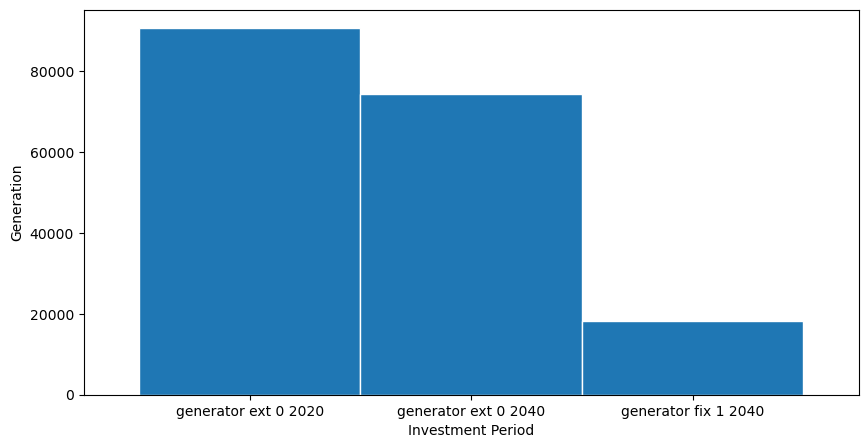

In [17]:
df = n.generators_t.p.sum(axis=0).T
df.T.plot.bar(
    stacked=True,
    edgecolor="white",
    width=1,
    ylabel="Generation",
    xlabel="Investment Period",
    rot=0,
    figsize=(10, 5),
)

In [14]:
n.global_constraints 

attribute,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,


In [ ]:
#so it does work, it will solve, but somehow the solver is not very iformative. 